In [21]:
import torch
from einops import rearrange
from jaxtyping import Float
from torch import Tensor

from jaxtyping import Float

In [3]:
# https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/transforms/rotation_conversions.py
def quaternion_to_matrix(
    quaternions: Float[Tensor, "*batch 4"],
    eps: float = 1e-8,
) -> Float[Tensor, "*batch 3 3"]:
    # Order changed to match scipy format!
    i, j, k, r = torch.unbind(quaternions, dim=-1)
    two_s = 2 / ((quaternions * quaternions).sum(dim=-1) + eps)

    o = torch.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
        ),
        -1,
    )
    return rearrange(o, "... (i j) -> ... i j", i=3, j=3)


def build_covariance(
    scale: Float[Tensor, "*#batch 3"],
    rotation_xyzw: Float[Tensor, "*#batch 4"],
) -> Float[Tensor, "*batch 3 3"]:
    scale = scale.diag_embed()
    rotation = quaternion_to_matrix(rotation_xyzw)
    return (
        rotation
        @ scale
        @ rearrange(scale, "... i j -> ... j i")
        @ rearrange(rotation, "... i j -> ... j i")
    )


In [4]:
scale_factors = torch.tensor([[2.0, 3.0, 4.0]])  # Shape: [1, 3]

# Define a quaternion for rotation (batch size of 1)
# Quaternion format: [i, j, k, r] where r is the real part
quaternion = torch.tensor([[0.0, 0.0, 0.707, 0.707]])  # Shape: [1, 4]


covariance_matrix = build_covariance(scale_factors, quaternion)

print("Covariance Matrix:")
print(covariance_matrix)
print(covariance_matrix.shape)

Covariance Matrix:
tensor([[[ 9.,  0.,  0.],
         [ 0.,  4.,  0.],
         [ 0.,  0., 16.]]])
torch.Size([1, 3, 3])


In [15]:
import torch
from einops import rearrange
from torch import Tensor
from dataclasses import dataclass

@dataclass
class Gaussians:
    mu: Tensor
    cov_matrix: Tensor
    w: Tensor

def quat_to_2d_mat(
    Q: Tensor,
    eps: float = 1e-8,
) -> Tensor:
    x, w = torch.unbind(Q, dim=-1)
    s2 = 2 / ((Q * Q).sum(dim=-1) + eps)

    M = torch.stack(
        (
            1 - s2 * (x * x),
            s2 * (w * x),
            -s2 * (w * x),
            1 - s2 * (x * x),
        ),
        -1,
    )
    return rearrange(M, "... (i j) -> ... i j", i=2, j=2)

def ang_to_rot_mat(
    theta: Tensor,
    eps: float = 1e-8,
) -> Tensor:
    theta = torch.unbind(theta, dim=-1)[0]
    
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    R = torch.stack(
        (
            cos_theta,
            -sin_theta,
            sin_theta,
            cos_theta
        ),
        -1,
    )
    return rearrange(R, "... (i j) -> ... i j", i=2, j=2)


def cov_mat_2d(
    scale: Tensor,
    theta: Tensor,
    epsilon: float = 1e-8
) -> Tensor:
    
    
    scale_mat = torch.diag_embed(torch.tril(scale + epsilon))
    
    R = ang_to_rot_mat(theta)
    
    cov_matrix = R @ scale_mat @ rearrange(scale_mat, "... i j -> ... j i") @ rearrange(R, "... i j -> ... j i")
    
    return cov_matrix

def extract_params(p, k, alpha) -> Gaussians:
    mu_x = p[:, :, :k].reshape(-1, k, 1)
    mu_y = p[:, :, k:2 * k].reshape(-1, k, 1)
    mu = torch.cat((mu_x, mu_y), 2).view(-1, k, 2)

    scale_idx = 3 * k
    scale = p[:, :, scale_idx:scale_idx + 2 * k].reshape(-1, k, 2)

    rot_idx = scale_idx + 2 * k
    theta = p[:, :, rot_idx:rot_idx + 2 * k].reshape(-1, k, 2)

    cov_matrix = cov_mat_2d(scale, theta)
    cov_matrix = torch.mul(cov_matrix, alpha)

    w = p[:, :, 2 * k:3 * k].reshape(-1, k)

    return Gaussians(mu, cov_matrix, w)

batch_size = 2
color = 3
num_kernels = 9
alpha = 1.0
p = torch.randn(batch_size, color, 63)

gaussians = extract_params(p, num_kernels, alpha)

print("mu shape:", gaussians.mu.shape)  # Expected: [27, 9, 2]
print("cov_matrix shape:", gaussians.cov_matrix.shape)  # Expected: [27, 9, 2, 2]
print("w shape:", gaussians.w.shape)  # Expected: [27, 9]
# print("Q shape:", gaussians.Q.shape)  # Expected: [27, 9, 2]

mu shape: torch.Size([6, 9, 2])
cov_matrix shape: torch.Size([6, 9, 2, 2])
w shape: torch.Size([6, 9])


In [16]:
gaussians.cov_matrix.min(), gaussians.cov_matrix.max()

(tensor(-1.2298), tensor(4.4037))

In [28]:
import torch
from torch import Tensor
from dataclasses import dataclass

@dataclass
class Gaussians:
    mu: Tensor
    cov_matrix: Tensor
    w: Tensor

def ang_to_rot_mat(theta: Tensor) -> Tensor:
    cos_theta = torch.cos(theta).unsqueeze(-1)
    sin_theta = torch.sin(theta).unsqueeze(-1)
    R = torch.cat([cos_theta, -sin_theta, sin_theta, cos_theta], dim=-1)
    return R.view(*theta.shape, 2, 2)

def cov_mat_2d(scale: Tensor, theta: Tensor, epsilon: float = 1e-8) -> Tensor:
    scale_mat = torch.diag_embed(scale + epsilon)
    R = ang_to_rot_mat(theta)
    cov_matrix = R @ scale_mat @ scale_mat.transpose(-2, -1) @ R.transpose(-2, -1)
    return cov_matrix

def extract_params(p: Tensor, k: int, alpha: float) -> Gaussians:
    mu_x = p[:, :, :k].reshape(-1, color, k, 1)
    mu_y = p[:, :, k:2*k].reshape(-1, color, k, 1)
    mu = torch.cat((mu_x, mu_y), -1).view(-1, color, k, 2)

    scale_idx = 3 * k
    scale = p[:, :, scale_idx:scale_idx + 2*k].reshape(-1, color, k, 2)

    rot_idx = scale_idx + 2 * k
    theta = p[:, :, rot_idx:rot_idx + k].reshape(-1, color, k)

    cov_matrix = cov_mat_2d(scale, theta)
    cov_matrix = torch.mul(cov_matrix, alpha)

    w = p[:, :, 2*k:3*k].reshape(-1, color, k)

    return Gaussians(mu, cov_matrix, w)


batch_size = 1
color = 3
num_kernels = 1
alpha = 1.0
p = torch.randn(batch_size, color, 63)  

gaussians = extract_params(p, num_kernels, alpha)

print("mu shape:", gaussians.mu.shape)  # Expected: [27, 3, 9, 2]
print("cov_matrix shape:", gaussians.cov_matrix.shape)  # Expected: [27, 3, 9, 2, 2]
print("w shape:", gaussians.w.shape) 

mu shape: torch.Size([1, 3, 1, 2])
cov_matrix shape: torch.Size([1, 3, 1, 2, 2])
w shape: torch.Size([1, 3, 1])


In [29]:
gaussians.cov_matrix.min(), gaussians.cov_matrix.max()

(tensor(0.1170), tensor(3.9083))

In [22]:
# def cov_mat_2d(scale: Tensor, theta: Tensor, epsilon: float = 1e-8) -> Tensor:
#     scale_mat = torch.diag_embed(scale + epsilon)
#     R = ang_to_rot_mat(theta)
#     cov_matrix = R @ scale_mat @ R.transpose(-2, -1)
#     return cov_matrix

In [30]:
theta_test = torch.tensor([[[0.2]]])  # Simple angle in radians
scale_test = torch.tensor([[[1.0, 0.5]]])  # Simple scale

cov_matrix_test = cov_mat_2d(scale_test, theta_test)
print("Covariance Matrix Test:\n", cov_matrix_test)

Covariance Matrix Test:
 tensor([[[[[0.9704, 0.1460],
           [0.1460, 0.2796]]]]])


In [199]:


# def grid_f(height, width):
#     xx = torch.linspace(0.0, 1.0, width)
#     yy = torch.linspace(0.0, 1.0, height)
#     grid_x, grid_y = torch.meshgrid(xx, yy, indexing="ij")
#     grid = torch.stack((grid_x, grid_y), 2).float()
#     return grid.reshape(height * width, 2)

# def forward(height, width, num_kernels, alpha, p):
#     gaussians = extract_params(p, num_kernels, alpha)
#     mu = gaussians.mu
#     cov_matrix = gaussians.cov_matrix
#     w = gaussians.w
#     grid = grid_f(height, width).to(p.device)
#     grid = grid.expand(mu.shape[0], mu.shape[1], -1, -1)
#     x = grid.unsqueeze(2)
#     mu = mu.unsqueeze(3)
#     x_sub_mu = (x - mu).unsqueeze(-1)

#     # Broadcast the cov_matrix for each spatial location
#     cov_matrix_inv = torch.linalg.inv(cov_matrix)
#     cov_matrix_inv_expanded = cov_matrix_inv.unsqueeze(2).expand(-1, -1, height*width, -1, -1)

#     x_sub_mu_t = x_sub_mu.transpose(-1, -2)
#     mahalanobis = torch.matmul(x_sub_mu_t, cov_matrix_inv_expanded)
#     mahalanobis = torch.matmul(mahalanobis, x_sub_mu).squeeze(-1).squeeze(-1)
#     e = torch.exp(-0.5 * mahalanobis)
#     g = torch.sum(e, dim=2, keepdim=True)
#     g_max = torch.clamp(g, min=1e-8)
#     e_norm = e / g_max
#     y_hat = torch.sum(e_norm * w.unsqueeze(-1), dim=2)
#     y_hat = y_hat.view(-1, 3, height, width)
#     y_hat = torch.clamp(y_hat, min=0, max=1)
#     return y_hat


# def forward(height, width, num_kernels, alpha, p):
#     gaussians = extract_params(p, num_kernels, alpha)

#     mu = gaussians.mu  # [batch_size, ch, num_kernels, 2]
#     cov_matrix = gaussians.cov_matrix  # [batch_size, ch, num_kernels, 2, 2]
#     w = gaussians.w  # [batch_size, ch, num_kernels]

#     grid = grid_f(height, width).to(p.device)  # [height, width, 2]
#     grid_expand_dim = grid.unsqueeze(0).unsqueeze(0)  # [1, 1, height, width, 2]
#     x = grid_expand_dim.expand(mu.shape[0], mu.shape[1], -1, -1, -1)  # [batch_size, ch, height, width, 2]

#     mu = mu.unsqueeze(2).unsqueeze(2)  # [batch_size, ch, 1, 1, num_kernels, 2]
#     x_sub_mu = (x.unsqueeze(4) - mu).unsqueeze(-1)  # [batch_size, ch, height, width, num_kernels, 2, 1]

#     # Corrected einsum operation to use cov_matrix twice and include torch.negative
#     e = torch.exp(
#         torch.negative(
#             0.5 * torch.einsum(
#                 "bchwdki,bcklm,bckmn,bchwdnj->bchwdk",
#                 x_sub_mu,
#                 cov_matrix,
#                 cov_matrix,
#                 x_sub_mu
#             ).squeeze(-1).squeeze(-1)
#         )
#     )  # [batch_size, ch, height, width, num_kernels]

#     g = torch.sum(e, dim=4, keepdim=True)  # [batch_size, ch, height, width, 1]
#     g_max = torch.clamp(g, min=1e-8)
#     e_norm = e / g_max

#     y_hat = torch.sum(e_norm * w.unsqueeze(2).unsqueeze(2), dim=4)  # [batch_size, ch, height, width]
#     y_hat = torch.clamp(y_hat, min=0, max=1)

#     return y_hat



import torch
from torch import Tensor
from dataclasses import dataclass

@dataclass
class Gaussians:
    mu: Tensor
    cov_matrix: Tensor
    w: Tensor

def extract_params(p, k, alpha):
    mu_x = p[:, :, :k].reshape(-1, 3, k, 1)
    mu_y = p[:, :, k:2*k].reshape(-1, 3, k, 1)
    mu = torch.cat((mu_x, mu_y), -1).view(-1, 3, k, 2)
    scale_idx = 3 * k
    scale = p[:, :, scale_idx:scale_idx + 2*k].reshape(-1, 3, k, 2)
    rot_idx = scale_idx + 2 * k
    theta = p[:, :, rot_idx:rot_idx + k].reshape(-1, 3, k)
    cov_matrix = cov_mat_2d(scale, theta)
    cov_matrix = torch.mul(cov_matrix, alpha)
    w = p[:, :, 2*k:3*k].reshape(-1, 3, k)
    return Gaussians(mu, cov_matrix, w)

def cov_mat_2d(scale, theta, epsilon=1e-8):
    scale_mat = torch.diag_embed(scale + epsilon)
    R = ang_to_rot_mat(theta)
    return R @ scale_mat @ scale_mat.transpose(-2, -1) @ R.transpose(-2, -1)

def ang_to_rot_mat(theta):
    cos_theta = torch.cos(theta).unsqueeze(-1)
    sin_theta = torch.sin(theta).unsqueeze(-1)
    R = torch.cat([cos_theta, -sin_theta, sin_theta, cos_theta], dim=-1)
    return R.view(*theta.shape, 2, 2)


def grid_f(height, width, channels):
    y = torch.linspace(-1, 1, height)
    x = torch.linspace(-1, 1, width)
    grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=-1)  # [height, width, 2]
    grid = grid.unsqueeze(0).expand(channels, -1, -1, -1)  # [channels, height, width, 2]
    return grid


def forward(height, width, num_kernels, alpha, p):
    gaussians = extract_params(p, num_kernels, alpha)

    mu = gaussians.mu  # [batch_size, ch, num_kernels, 2]
    cov_matrix = gaussians.cov_matrix  # [batch_size, ch, num_kernels, 2, 2]
    w = gaussians.w  # [batch_size, ch, num_kernels]

    grid = grid_f(height, width).to(p.device)  # [height, width, 2]

    print(f'grid shape: {grid.shape}')

    grid_expand_dim = grid.unsqueeze(0).unsqueeze(0)  # [1, 1, height, width, 2]
    x = grid_expand_dim.expand(mu.shape[0], mu.shape[1], -1, -1, -1)  # [batch_size, ch, height, width, 2]

    mu = mu.unsqueeze(2).unsqueeze(2)  # [batch_size, ch, 1, 1, num_kernels, 2]
    x_sub_mu = (x.unsqueeze(4) - mu).unsqueeze(-1)  # [batch_size, ch, height, width, num_kernels, 2, 1]

    
    print(f'cov_matrix shape: {cov_matrix.shape}')  
    print(f'x_sub_mu shape: {x_sub_mu.shape}')


    e = torch.exp(
        torch.negative(
            0.5 * torch.einsum("bchwdki,bcklm,bckmn,bchwdnj->bchwdk", x_sub_mu, cov_matrix, cov_matrix, x_sub_mu)
        )
    )  # [batch_size, ch, height, width, num_kernels]

    g = torch.sum(e, dim=4, keepdim=True)  # [batch_size, ch, height, width, 1]
    g_max = torch.clamp(g, min=1e-8)
    e_norm = e / g_max

    y_hat = torch.sum(e_norm * w.unsqueeze(2).unsqueeze(2), dim=4)  # [batch_size, ch, height, width]
    y_hat = torch.clamp(y_hat, min=0, max=1)

    return y_hat

In [200]:
batch_size = 9
color = 1
num_kernels = 9
alpha = 1.0
height = 16
width = 16

z = 2 * num_kernels + 4 * num_kernels + num_kernels
print(z)
p = torch.randn(batch_size, color, z)  
p.shape

63


torch.Size([9, 1, 63])

In [201]:
gaussians = extract_params(p, num_kernels, alpha)

print("mu shape:", gaussians.mu.shape)  # Expected: [27, 3, 9, 2]
print("cov_matrix shape:", gaussians.cov_matrix.shape)  # Expected: [27, 3, 9, 2, 2]
print("w shape:", gaussians.w.shape)

mu shape: torch.Size([3, 3, 9, 2])
cov_matrix shape: torch.Size([3, 3, 9, 2, 2])
w shape: torch.Size([3, 3, 9])


In [237]:
import torch
from torch import Tensor
from dataclasses import dataclass

@dataclass
class Gaussians:
    mu: Tensor
    cov_matrix: Tensor
    w: Tensor

def extract_params(p, k, alpha):
    batch_size, ch, _ = p.shape
    mu_x = p[:, :, :k].reshape(batch_size, ch, k, 1)
    mu_y = p[:, :, k:2*k].reshape(batch_size, ch, k, 1)
    mu = torch.cat((mu_x, mu_y), dim=3).view(batch_size, ch, k, 2)
    scale_idx = 2 * k
    scale = p[:, :, scale_idx:scale_idx + 2*k].reshape(batch_size, ch, k, 2)
    rot_idx = scale_idx + 2 * k
    theta = p[:, :, rot_idx:rot_idx + k].reshape(batch_size, ch, k)
    cov_matrix = cov_mat_2d(scale, theta)
    cov_matrix = torch.mul(cov_matrix, alpha)
    w = p[:, :, rot_idx + k:rot_idx + 2*k].reshape(batch_size, ch, k)
    return Gaussians(mu, cov_matrix, w)

def cov_mat_2d(scale, theta, epsilon=1e-8):
    scale_mat = torch.diag_embed(scale + epsilon)
    R = ang_to_rot_mat(theta)
    return R @ scale_mat @ R.transpose(-2, -1)

def ang_to_rot_mat(theta):
    cos = torch.cos(theta).unsqueeze(-1)
    sin = torch.sin(theta).unsqueeze(-1)
    R = torch.cat([cos, -sin, sin, cos], dim=-1)
    return R.view(*theta.shape, 2, 2)

def grid_f(height, width, channels):
    y = torch.linspace(-1, 1, height)
    x = torch.linspace(-1, 1, width)
    grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=-1)
    return grid.unsqueeze(0).expand(channels, -1, -1, -1)  # [channels, height, width, 2]

def forward(height, width, num_kernels, alpha, p):
    gaussians = extract_params(p, num_kernels, alpha)
    
    
    grid = grid_f(height, width, gaussians.mu.shape[1]).to(p.device)  # [ch, height, width, 2]
    grid_expand = grid.unsqueeze(0).expand(gaussians.mu.shape[0], -1, -1, -1, -1)  # [batch_size, ch, height, width, 2]

    # Calculate x - mu
    x_sub_mu = grid_expand.unsqueeze(4) - gaussians.mu.unsqueeze(2).unsqueeze(2)  # [batch_size, ch, height, width, num_kernels, 2]
    x_sub_mu = x_sub_mu.view(gaussians.mu.shape[0], gaussians.mu.shape[1], height, width, num_kernels, 2, 1)  # reshaping for matrix multiplication

    # Ensure dimensions match for matrix multiplication
    cov_matrix_expanded = gaussians.cov_matrix.unsqueeze(2).unsqueeze(2)  # [batch_size, ch, 1, 1, num_kernels, 2, 2]
    cov_matrix_expanded = cov_matrix_expanded.expand(-1, -1, height, width, -1, -1, -1)  # expand dimensions to match x_sub_mu

    # Matrix multiplication: (2, 1) * (2, 2) -> (2, 1)
    intermediate = torch.matmul(cov_matrix_expanded, x_sub_mu)  # [batch_size, ch, height, width, num_kernels, 2, 1]

    # Calculate the exponent using the dot product in the last two dimensions
    exponent = -0.5 * x_sub_mu.transpose(-2, -1).matmul(intermediate).squeeze(-1).squeeze(-1)  # [batch_size, ch, height, width, num_kernels]

    # Summing exponentials over kernels and applying weights
    e = torch.exp(exponent)
    g = torch.sum(e * gaussians.w.unsqueeze(2).unsqueeze(2), dim=4, keepdim=True)  # Weighted sum over kernels
    g_max = torch.clamp(g, min=1e-8)
    e_norm = e / g_max

    # Weighted sum over kernels
    y_hat = torch.sum(e_norm * gaussians.w.unsqueeze(2).unsqueeze(2), dim=4)  # [batch_size, ch, height, width]
    y_hat = torch.clamp(y_hat, min=0, max=1)

    return y_hat

# Test the code
batch_size = 3
color = 1
num_kernels = 16
alpha = 1.0
height = 120
width = 120
z = 2 * num_kernels + 4 * num_kernels + num_kernels
p = torch.randn(batch_size, color, z)

y_hat = forward(height, width, num_kernels, alpha, p)
print("y_hat shape:", y_hat.shape)  # Expected: [batch_size, ch, height, width]

y_hat shape: torch.Size([3, 1, 120, 120])


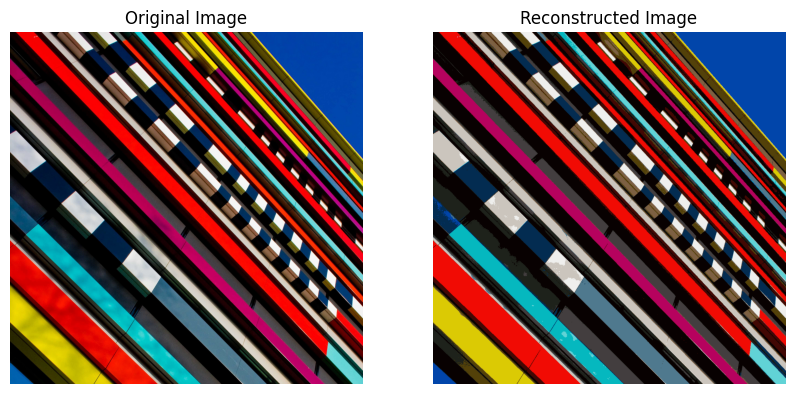

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.io import imread, imsave

# Step 1: Load the image
image = imread('/home/ozkan/works/n-smoe/utils_n/test.png')
image_shape = image.shape

# Step 2: Preprocess the image
# Reshape the image to a 2D array of pixels
pixels = image.reshape(-1, 3)

# Step 3: Apply K-means clustering
k = 16  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pixels)

# Step 4: Assign cluster centers to pixels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Step 5: Reconstruct the image
reconstructed_image = cluster_centers[labels].reshape(image_shape).astype(np.uint8)

# Step 6: Display the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image)
plt.axis('off')

plt.show()

# Save the reconstructed image
imsave('reconstructed_image.jpg', reconstructed_image)


In [3]:
cluster_centers.shape

(16, 3)